# Text Classification Using Bag Of Words and tf-Idf

In this example, we will classify documents using bag of words features -- first, unweighted, and then weighted using Term Frequency - Inverse Document Frequency (tf-idf).

The example is based on the [Working With Text Data example from scikit-learn](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html).

## Import Packages and Load Data

We will use the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/), which already is available in scikit-learn. We will extract a subset of the 20 categories and get the training and test subsets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.datasets import fetch_20newsgroups
random_seed = 42
categories = ["rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey", 
              "sci.crypt", "sci.electronics", "sci.med", "sci.space"] # Set to None for all categories
train_data = fetch_20newsgroups(subset="train", categories=categories, 
                                shuffle=True, random_state=random_seed)
test_data = fetch_20newsgroups(subset="test", categories=categories, 
                               shuffle=True, random_state=random_seed)
print(train_data.target_names)

['rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']


## Extract Bag of Words Features

Now we will extract bag of words features using the [CountVectorizer in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).

In [3]:
# Extract Bag of Words features
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(train_data.data)
train_shape = X_train_counts.shape
print("Training data has {} elements and {} features".format(
    train_shape[0], train_shape[1]))

# Test these features on a few sample sentences
sample_sentences = ["The Hubble Space Telescope was launched into low Earth orbit in 1990",
                    "Audi has an all-wheel drive technology named Quattro on some of its vehicles",
                    "Resistors dissipate heat proportional to the square of the current through them",
                    "Barry Bonds holds the record for hitting the most home runs",
                    "The current global pandemic is due to the COVID-19 respiratory disease"]
sample_data = count_vect.transform(sample_sentences).toarray()

print("\nSAMPLE DATA")
for i, elem in enumerate(sample_data):
    print(sample_sentences[i])
    print(np.nonzero(elem)[0])
    print("")

Training data has 4762 elements and 55472 features

SAMPLE DATA
The Hubble Space Telescope was launched into low Earth orbit in 1990
[ 3122 21193 27833 28578 29386 31971 32984 38151 47142 49723 49968 53703]

Audi has an all-wheel drive technology named Quattro on some of its vehicles
[ 9748 10088 11282 20800 26707 29738 36305 37756 37955 41862 46994 49633
 52865 54087]

Resistors dissipate heat proportional to the square of the current through them
[18296 20226 26882 37756 41306 43340 47561 49968 49985 50218 50483]

Barry Bonds holds the record for hitting the most home runs
[11912 13124 24123 27325 27449 27489 35636 42585 44419 49968]

The current global pandemic is due to the COVID-19 respiratory disease
[ 2892 18296 20113 20957 25492 29607 43376 49968 50483]



## Train and Evaluate a Classifier

We will create a learning pipeline with two steps:

1. Extract bag of words features
2. Train a linear Support Vector Machine (SVM) classifier 

Training Accuracy: 99.85%
Test Accuracy: 88.26%

SAMPLE DATA
Sentence: The Hubble Space Telescope was launched into low Earth orbit in 1990
Prediction: sci.space

Sentence: Audi has an all-wheel drive technology named Quattro on some of its vehicles
Prediction: rec.autos

Sentence: Resistors dissipate heat proportional to the square of the current through them
Prediction: sci.electronics

Sentence: Barry Bonds holds the record for hitting the most home runs
Prediction: rec.sport.baseball

Sentence: The current global pandemic is due to the COVID-19 respiratory disease
Prediction: sci.med



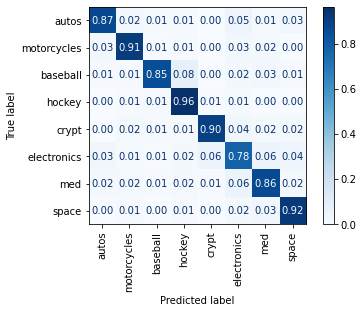

In [4]:
# Create the learning pipeline and fit the model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
classifier = SGDClassifier(loss="hinge", penalty="l2",
                           alpha=1e-3, random_state=random_seed,
                           max_iter=5, tol=None)
model = Pipeline([
     ("vect", count_vect),
     ("clf", classifier),
])
model.fit(train_data.data, train_data.target)

# Predict on the training and test data
train_predicted = model.predict(train_data.data)
test_predicted = model.predict(test_data.data)
train_accuracy = np.mean(train_predicted == train_data.target)
test_accuracy = np.mean(test_predicted == test_data.target)
print("Training Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))

# Predict on the sample sentences and display results
print("\nSAMPLE DATA")
sample_predicted = model.predict(sample_sentences)
for i, pred in enumerate(sample_predicted):
    print("Sentence: {}\nPrediction: {}\n".format(
        sample_sentences[i], categories[pred]))

# Plot the confusion matrix
from sklearn.metrics import plot_confusion_matrix
display_labels = [cat.split(".")[-1] for cat in categories]
disp = plot_confusion_matrix(model, test_data.data, test_data.target,
                             display_labels=display_labels,
                             cmap=plt.cm.Blues,
                             normalize="true",
                             xticks_rotation="vertical",
                             values_format=".2f")
plt.show()

## Add tf-idf weighting

Now we will use the [TfidfTransformer in scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) to weigh the bag of words features and include them in our learning pipeline.

The pipeline is now:
1. Extract bag of words features
2. Weight the features using tf-idf
3. Train a linear Support Vector Machine (SVM) classifier

Looking at the results, tf-idf seems to improve test accuracy without much reduction in training accuracy.

IDF weights:
[4.29814901 4.25914685 7.67687353 ... 8.77548582 8.37002071 8.08233864]

Training Accuracy: 99.50%
Test Accuracy: 93.91%

SAMPLE DATA
Sentence: The Hubble Space Telescope was launched into low Earth orbit in 1990
Prediction: sci.space

Sentence: Audi has an all-wheel drive technology named Quattro on some of its vehicles
Prediction: rec.autos

Sentence: Resistors dissipate heat proportional to the square of the current through them
Prediction: sci.electronics

Sentence: Barry Bonds holds the record for hitting the most home runs
Prediction: rec.sport.baseball

Sentence: The current global pandemic is due to the COVID-19 respiratory disease
Prediction: sci.med



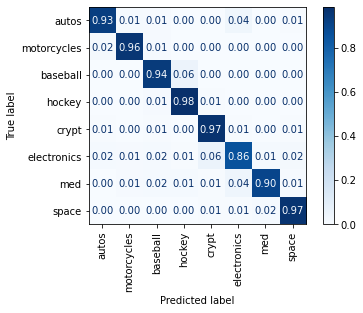

In [5]:
# Create the learning pipeline and fit the model
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer()
tfidf_transformer = TfidfTransformer()
classifier = SGDClassifier(loss="hinge", penalty="l2",
                           alpha=1e-3, random_state=random_seed,
                           max_iter=5, tol=None)
model = Pipeline([
     ("vect", count_vect),
     ("tfidf", tfidf_transformer),
     ("clf", classifier),
])
model.fit(train_data.data, train_data.target)
print("IDF weights:")
print(model["tfidf"].idf_)
print("")

# Predict on the training and test data
train_predicted = model.predict(train_data.data)
test_predicted = model.predict(test_data.data)
train_accuracy = np.mean(train_predicted == train_data.target)
test_accuracy = np.mean(test_predicted == test_data.target)
print("Training Accuracy: {:.2f}%".format(train_accuracy*100))
print("Test Accuracy: {:.2f}%".format(test_accuracy*100))

# Predict on the sample sentences and display results
print("\nSAMPLE DATA")
sample_predicted = model.predict(sample_sentences)
for i, pred in enumerate(sample_predicted):
    print("Sentence: {}\nPrediction: {}\n".format(
        sample_sentences[i], categories[pred]))

# Plot the confusion matrix
display_labels = [cat.split(".")[-1] for cat in categories]
disp = plot_confusion_matrix(model, test_data.data, test_data.target,
                             display_labels=display_labels,
                             cmap=plt.cm.Blues,
                             normalize="true",
                             xticks_rotation="vertical",
                             values_format=".2f")
plt.show()